2022 Nor-s

## [사전학습 모델 사용](https://yeong-jin-data-blog.tistory.com/entry/%EC%82%AC%EC%A0%84%ED%95%99%EC%8A%B5-%EB%AA%A8%EB%8D%B8-%EC%82%AC%EC%9A%A9)

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Reshape, Conv2D, Conv1D
from tensorflow.keras import models
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import math
import numpy as np
 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
TRAIN_DATA_DIR = '../data/for_generator/train'
VALIDATION_DATA_DIR = '../data/for_generator/val'
TEST_DATA_DIR = '../data/for_generator/test'
 
TRAIN_SAMPLES = 24000
VALIDATION_SAMPLES = 3000
NUM_CLASSES = 2
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 64

## 데이터 로드

https://keras.io/api/preprocessing/image/

In [3]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2)
 
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [4]:
train_generator = train_datagen.flow_from_directory(TRAIN_DATA_DIR,
                                                    target_size=(IMG_WIDTH,
                                                                 IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    seed=12345,
                                                    class_mode='categorical')
 
validation_generator = val_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')

Found 24000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.


## VGG model 사전학습 모델

In [5]:
from tensorflow.keras.applications.vgg16 import VGG16
def model_maker(num_class, input_shape=(224, 224, 3)):
    # model = VGG16(weights='imagenet', include_top=True)
    base_model = VGG16(include_top=False, input_shape=input_shape)
    print(len(base_model.layers))
 
    for layer in base_model.layers[:]:
        layer.trainable = False
 
    input = tf.keras.Input(shape=input_shape)
    custom_model = base_model(input)
    custom_model = tf.keras.layers.GlobalAveragePooling2D()(custom_model)
    custom_model = tf.keras.layers.Dense(32, activation='relu')(custom_model)
    predictions = tf.keras.layers.Dense(num_class, activation='softmax')(custom_model)
    
    return tf.keras.Model(inputs=input, outputs=predictions)

model_final = model_maker(2, input_shape=(224, 224, 3))
model_final.summary()
model_final.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['acc'])

19
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 32)                16416     
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 14,731,170
Trainable params: 16,482
Non-trainable params: 14,714,688
_________________________________________

In [6]:
checkpoint_path = "./VGG/cp-{epoch:04d}.ckpt"   # 3
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                #  period=5,
                                                 monitor='val_acc',
                                                mode='max',
                                                 save_best_only=True)

history = model_final.fit(
    train_generator,
    steps_per_epoch=TRAIN_SAMPLES // BATCH_SIZE, # number of updates
    epochs=100,
    validation_data=validation_generator,
    validation_steps=VALIDATION_SAMPLES // BATCH_SIZE,
    callbacks=[cp_callback ])

Epoch 1/100
375/375 [==============================] - ETA: 0s - loss: 0.5544 - acc: 0.7255
Epoch 1: val_acc improved from -inf to 0.74864, saving model to ./VGG\cp-0001.ckpt
375/375 [==============================] - 263s 678ms/step - loss: 0.5544 - acc: 0.7255 - val_loss: 0.5163 - val_acc: 0.7486
Epoch 2/100
375/375 [==============================] - ETA: 0s - loss: 0.5101 - acc: 0.7520
Epoch 2: val_acc improved from 0.74864 to 0.76121, saving model to ./VGG\cp-0002.ckpt
375/375 [==============================] - 258s 686ms/step - loss: 0.5101 - acc: 0.7520 - val_loss: 0.4926 - val_acc: 0.7612
Epoch 3/100
375/375 [==============================] - ETA: 0s - loss: 0.5026 - acc: 0.7586
Epoch 3: val_acc improved from 0.76121 to 0.76834, saving model to ./VGG\cp-0003.ckpt
375/375 [==============================] - 258s 687ms/step - loss: 0.5026 - acc: 0.7586 - val_loss: 0.4827 - val_acc: 0.7683
Epoch 4/100
375/375 [==============================] - ETA: 0s - loss: 0.4973 - acc: 0.7606
Ep

KeyboardInterrupt: 

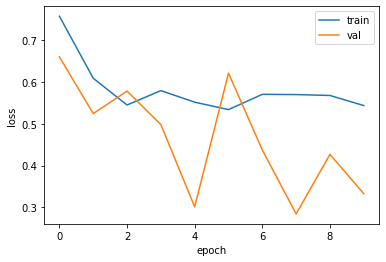

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

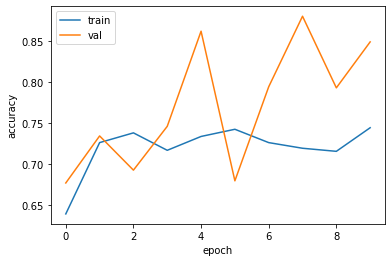

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'])
plt.show()